### Validity testing processed obs data ###

Using Hannah's scripts and some questionable interpretation of this, I have converted daily ERA5 field for wind speed and temperature into (onshore and offshore) wind power capacity factors and weather dependent electricity demand.

I want to verify that these time series are producing reasonable values and functioning as expected. To do this, I will plot the time series for demand, wind power, and demand net wind over the time period 1960-2019. A particular focus is whether the low wind speeds and high demand of the early 1960s and around 2010 show up.

In [1]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set up the global variables
csvs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs/"

# Set up the file names
fname_onshore_uk = "United_Kingdom_obs_wind_speed_cfs_ons.csv"
fname_offshore_uk = "United_Kingdom_obs_wind_speed_cfs_ofs.csv"
fname_wd_demand_uk = "obs_wd_demand_1960_2019_United_Kingdom.csv"

# Set up the values of installed capacities in 2023
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

In [3]:
# Load the individual dataframes
df_onshore = pd.read_csv(os.path.join(csvs_dir, fname_onshore_uk))
df_offshore = pd.read_csv(os.path.join(csvs_dir, fname_offshore_uk))
df_demand = pd.read_csv(os.path.join(csvs_dir, fname_wd_demand_uk))

In [4]:
# Set up time column to be datetime
df_onshore["time"] = pd.to_datetime(df_onshore["time"])

# set this as index
df_onshore.set_index("time", inplace=True)

# Set up time column to be datetime
df_offshore["time"] = pd.to_datetime(df_offshore["time"])

# set this as index
df_offshore.set_index("time", inplace=True)

# set up the Unnamed: 0 column as a datetime
df_demand["Unnamed: 0"] = pd.to_datetime(df_demand["Unnamed: 0"])

# set this as index
df_demand.set_index("Unnamed: 0", inplace=True)

In [5]:
df_offshore

,obs_wind_speed_100m_bc,obs_cfs_ofs
time,,
1960-11-01,11.325152,0.826896
1960-11-02,14.248714,0.874877
1960-11-03,10.112684,0.661860
1960-11-04,8.534932,0.496145
1960-11-05,7.439478,0.326865
...,...,...
2019-10-26,8.963854,0.526947
2019-10-27,8.090914,0.440908
2019-10-28,5.917435,0.166644


In [6]:
# join the onshore and offshore dataframes
df_wind = pd.concat([df_onshore, df_offshore], axis=1)

In [7]:
# join the wind and demand dataframes
df = pd.concat([df_wind, df_demand], axis=1)

In [8]:
df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_wind_speed_100m_bc,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,11.325152,0.699079,11.325152,0.826896,9.970184,5.529816,0.0,39.190225
1960-11-02,14.248714,0.804985,14.248714,0.874877,8.484436,7.015564,0.0,40.300983
1960-11-03,10.112684,0.553986,10.112684,0.661860,6.850250,8.649750,0.0,41.522715
1960-11-04,8.534932,0.419052,8.534932,0.496145,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439478,0.249140,7.439478,0.326865,7.439514,8.060486,0.0,41.082176


In [9]:
# remove one of the obs_wind_speed_100m_bc columns
df = df.loc[:, ~df.columns.duplicated()]

In [10]:
df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,11.325152,0.699079,0.826896,9.970184,5.529816,0.0,39.190225
1960-11-02,14.248714,0.804985,0.874877,8.484436,7.015564,0.0,40.300983
1960-11-03,10.112684,0.553986,0.661860,6.850250,8.649750,0.0,41.522715
1960-11-04,8.534932,0.419052,0.496145,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439478,0.249140,0.326865,7.439514,8.060486,0.0,41.082176


In [11]:
# new column for ons_wind_power
df["ons_wind_power"] = df["obs_cfs_ons"] * installed_ons_2023
df["ofs_wind_power"] = df["obs_cfs_ofs"] * installed_ofs_2023

In [12]:
df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,ons_wind_power,ofs_wind_power
1960-11-01,11.325152,0.699079,0.826896,9.970184,5.529816,0.0,39.190225,10.392515,12.201679
1960-11-02,14.248714,0.804985,0.874877,8.484436,7.015564,0.0,40.300983,11.966914,12.909687
1960-11-03,10.112684,0.553986,0.661860,6.850250,8.649750,0.0,41.522715,8.235563,9.766404
1960-11-04,8.534932,0.419052,0.496145,7.034576,8.465424,0.0,41.384911,6.229633,7.321120
1960-11-05,7.439478,0.249140,0.326865,7.439514,8.060486,0.0,41.082176,3.703711,4.823227


In [13]:
# set up the save dir
save_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs/"

# save the dataframe
df.to_csv(os.path.join(save_dir, "obs_wind_power_demand_uk.csv"))

In [14]:
# Take the annual means of the data
df_annual = df.resample("Y").mean()

In [15]:
df_annual.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,ons_wind_power,ofs_wind_power
1960-12-31,7.766555,0.330001,0.398878,4.946378,10.553622,0.0,42.946066,4.905793,5.885843
1961-12-31,7.247340,0.286266,0.351450,8.941989,6.598530,0.0,39.989205,4.255623,5.186001
1962-12-31,7.359206,0.297566,0.363208,7.506522,7.993478,0.0,41.032080,4.423612,5.359503
1963-12-31,7.154399,0.275794,0.340832,7.187788,8.329230,0.0,41.283091,4.099960,5.029313
1964-12-31,7.094441,0.275041,0.338863,8.280141,7.243305,0.0,40.471244,4.088753,5.000266


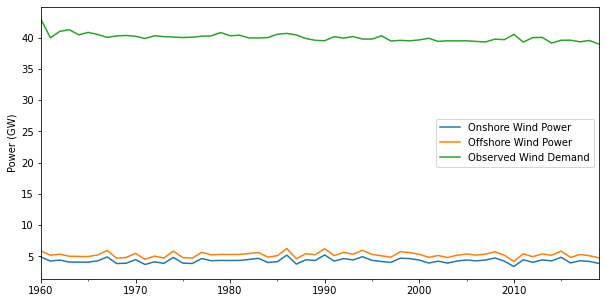

In [16]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

df_annual["ons_wind_power"].plot(ax=ax, label="Onshore Wind Power")
df_annual["ofs_wind_power"].plot(ax=ax, label="Offshore Wind Power")
df_annual["United_Kingdom_demand"].plot(ax=ax, label="Observed Wind Demand")

ax.set_ylabel("Power (GW)")

ax.legend()

In [17]:
# test that the climatology is doing something semi realistic
df_subset = df.loc["1990":]

In [18]:
# perform a rolling climatology
rolling_clim = df_subset.rolling(window="14D", min_periods=1, center=False).mean()

# Add a new column for the day of the year
rolling_clim = rolling_clim.assign(day_of_year=rolling_clim.index.dayofyear)

# Calculate the mean for each day of the year
climatology = rolling_clim.groupby("day_of_year").mean()

In [19]:
# new column for the total wind power
climatology["total_wind_power"] = climatology["ons_wind_power"] + climatology["ofs_wind_power"]

In [20]:
# new column for demand net wind
climatology["demand_net_wind"] = climatology["United_Kingdom_demand"] - climatology["total_wind_power"]

Text(0.5, 1.0, 'Climatology of UK Wind Power 1990-2019')

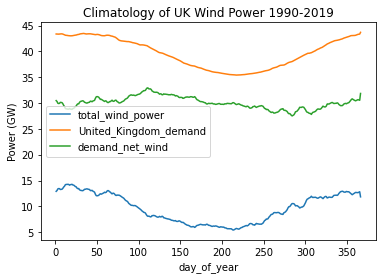

In [21]:
# plot the climatology
climatology["total_wind_power"].plot()
climatology["United_Kingdom_demand"].plot()
climatology["demand_net_wind"].plot()

# ylabels
plt.ylabel("Power (GW)")

# legend
plt.legend()

# title
plt.title("Climatology of UK Wind Power 1990-2019")

Seem to capture the right variability, but the absolute values are slightly off relative to Hannah's. It would be useful to load up clearheads to compare.

In [22]:
# clearheads_dir
ch_file = "/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2023_daily_SP_WP_demand_wind.csv"

# Load up this file
ch_df = pd.read_csv(ch_file)

In [23]:
ch_df.head()

,date,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,United_Kingdom_solar_gen,demand_net_wind,wd_demand_net_wind,demand_net_renewables,wd_demand_net_renewables,demandESO,demandESO_net_wind,demandESO_net_renewables
0,1940-01-01,0.016125,0.344934,46.420023,47.228293,6.961509,-0.688529,10.217639,0.248370,36.202385,37.010655,35.954015,36.762285,NaN,NaN,NaN
1,1940-01-02,0.013857,0.235733,47.953306,47.953306,5.675701,-1.658305,6.982887,0.213429,40.970419,40.970419,40.756990,40.756990,NaN,NaN,NaN
2,1940-01-03,0.093672,0.386296,47.568234,47.568234,7.631405,-1.143233,11.442862,1.442796,36.125371,36.125371,34.682575,34.682575,NaN,NaN,NaN
3,1940-01-04,0.094658,0.468219,46.787436,46.787436,8.341800,-0.098840,13.869574,1.457991,32.917862,32.917862,31.459871,31.459871,NaN,NaN,NaN
4,1940-01-05,0.111828,0.168710,46.014368,46.914110,5.555250,-0.268279,4.997523,1.722460,41.016845,41.916587,39.294385,40.194127,NaN,NaN,NaN


In [24]:
# set up suffix for all of ch_df columns
# _ch
ch_df.columns = [f"{col}_ch" for col in ch_df.columns]

In [25]:
# convert date to datetime
ch_df["date_ch"] = pd.to_datetime(ch_df["date_ch"])

# set this as index
ch_df.set_index("date_ch", inplace=True)

# remove the name of the index
ch_df.index.name = None

In [26]:
# join df with ch_df
# df = pd.concat([df, ch_df], axis=1)
ben_ch_df = df.join(ch_df)

In [27]:
ben_ch_df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,ons_wind_power,ofs_wind_power,United_Kingdom_solar_cf_ch,...,UK_temp_ch,United_Kingdom_wind_gen_ch,United_Kingdom_solar_gen_ch,demand_net_wind_ch,wd_demand_net_wind_ch,demand_net_renewables_ch,wd_demand_net_renewables_ch,demandESO_ch,demandESO_net_wind_ch,demandESO_net_renewables_ch
1960-11-01,11.325152,0.699079,0.826896,9.970184,5.529816,0.0,39.190225,10.392515,12.201679,0.018772,...,9.852619,22.314514,0.289145,17.033125,17.033125,16.743980,16.743980,NaN,NaN,NaN
1960-11-02,14.248714,0.804985,0.874877,8.484436,7.015564,0.0,40.300983,11.966914,12.909687,0.039474,...,8.381276,21.720069,0.608001,18.727559,18.727559,18.119558,18.119558,NaN,NaN,NaN
1960-11-03,10.112684,0.553986,0.661860,6.850250,8.649750,0.0,41.522715,8.235563,9.766404,0.058489,...,6.608210,20.118652,0.900881,21.654535,21.654535,20.753654,20.753654,NaN,NaN,NaN
1960-11-04,8.534932,0.419052,0.496145,7.034576,8.465424,0.0,41.384911,6.229633,7.321120,0.164698,...,7.129905,15.591910,2.536795,24.891511,25.791254,22.354716,23.254459,NaN,NaN,NaN
1960-11-05,7.439478,0.249140,0.326865,7.439514,8.060486,0.0,41.082176,3.703711,4.823227,0.199009,...,7.330855,15.395524,3.065269,21.993496,25.837408,18.928228,22.772139,NaN,NaN,NaN


In [28]:
# perform a rolling climatology for full period
rolling_clim_full = ben_ch_df.rolling(window="14D", min_periods=1, center=False).mean()

# Add a new column for the day of the year
rolling_clim_full = rolling_clim_full.assign(day_of_year=rolling_clim_full.index.dayofyear)

# Calculate the mean for each day of the year
climatology_full = rolling_clim_full.groupby("day_of_year").mean()

Text(0.5, 1.0, 'Climatology of UK Demand 1960-2019: Ben vs. Hannah')

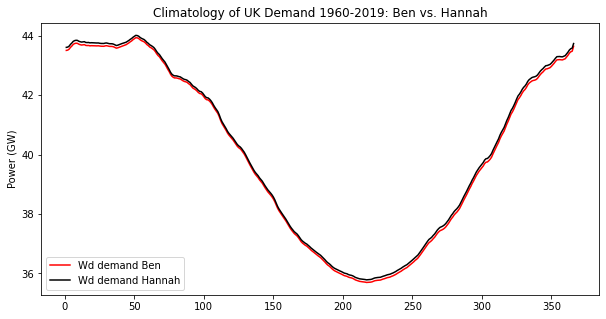

In [29]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom demand
plt.plot(climatology_full.index, climatology_full["United_Kingdom_demand"], label="Wd demand Ben", color="red")
plt.plot(climatology_full.index, climatology_full["United_Kingdom_wd_demand_ch"], label="Wd demand Hannah", color="black")

# ylabels
plt.ylabel("Power (GW)")

# legend
plt.legend()

# title
plt.title("Climatology of UK Demand 1960-2019: Ben vs. Hannah")

Text(0.5, 1.0, 'Climatology of UK Wind Capacity Factors 1960-2019: Ben vs. Hannah')

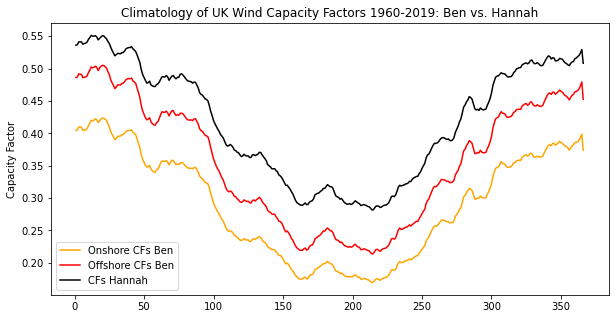

In [30]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom capacity factors
plt.plot(climatology_full.index, climatology_full["obs_cfs_ons"], label="Onshore CFs Ben", color="orange")
plt.plot(climatology_full.index, climatology_full["obs_cfs_ofs"], label="Offshore CFs Ben", color="red")
plt.plot(climatology_full.index, climatology_full["United_Kingdom_wind_cf_ch"], label="CFs Hannah", color="black")

# ylabels
plt.ylabel("Capacity Factor")

# legend
plt.legend()

# title
plt.title("Climatology of UK Wind Capacity Factors 1960-2019: Ben vs. Hannah")

Would also be useful to compare the source variables - e.g. wind speeds (at hub height) and UK mean temperature. I imagine that temperature (aggregated daily in both cases) will be comparable, while the wind speeds at hub height will be slightly different.

If we only care about the magnitude of demand net wind anomalies, then surely the absolute values don't really matter?

In [31]:
climatology_full.columns

Index(['obs_wind_speed_100m_bc', 'obs_cfs_ons', 'obs_cfs_ofs',
       'United_Kingdom_t2m', 'United_Kingdom_hdd', 'United_Kingdom_cdd',
       'United_Kingdom_demand', 'ons_wind_power', 'ofs_wind_power',
       'United_Kingdom_solar_cf_ch', 'United_Kingdom_wind_cf_ch',
       'United_Kingdom_demand_ch', 'United_Kingdom_wd_demand_ch',
       'UK_wind_speed_ch', 'UK_temp_ch', 'United_Kingdom_wind_gen_ch',
       'United_Kingdom_solar_gen_ch', 'demand_net_wind_ch',
       'wd_demand_net_wind_ch', 'demand_net_renewables_ch',
       'wd_demand_net_renewables_ch', 'demandESO_ch', 'demandESO_net_wind_ch',
       'demandESO_net_renewables_ch'],
      dtype='object')

### UK Temperature comparison ###

Text(0.5, 1.0, 'Climatology of UK Temperature 1960-2019: Ben vs. Hannah')

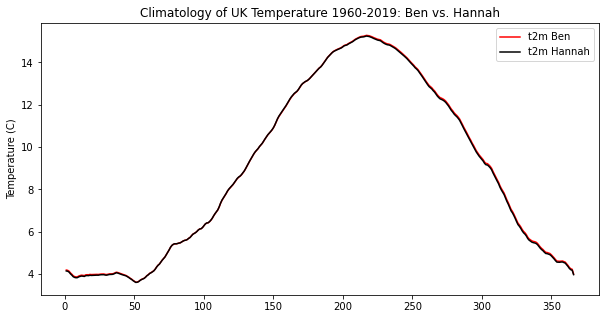

In [32]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom capacity factors
plt.plot(climatology_full.index, climatology_full["United_Kingdom_t2m"], label="t2m Ben", color="red")
plt.plot(climatology_full.index, climatology_full["UK_temp_ch"], label="t2m Hannah", color="black")

# ylabels
plt.ylabel("Temperature (C)")

# legend
plt.legend()

# title
plt.title("Climatology of UK Temperature 1960-2019: Ben vs. Hannah")

### UK wind speed comparison ###

* Ben -> bias corrected (to global wind atlas) 100m wind speed
* Hannah -> wind speed at hub height (~100m)

Text(0.5, 1.0, 'Climatology of UK mean wind speed 1960-2019: Ben vs. Hannah')

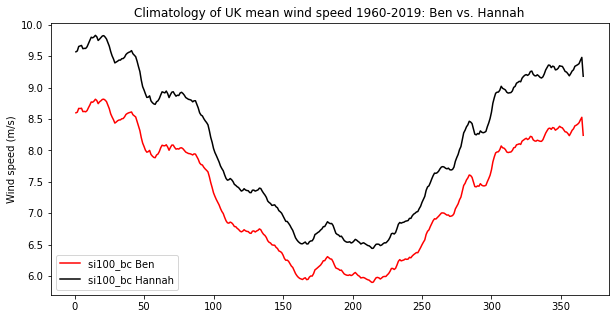

In [33]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom capacity factors
plt.plot(climatology_full.index, climatology_full["obs_wind_speed_100m_bc"], label="si100_bc Ben", color="red")
plt.plot(climatology_full.index, climatology_full["UK_wind_speed_ch"], label="si100_bc Hannah", color="black")

# ylabels
plt.ylabel("Wind speed (m/s)")

# legend
plt.legend()

# title
plt.title("Climatology of UK mean wind speed 1960-2019: Ben vs. Hannah")

Wind speeds consistently too low -> result of using daily data rather than hourly data?

In [34]:
# Quantify total wind power
climatology_full["total_wind_power"] = climatology_full["ons_wind_power"] + climatology_full["ofs_wind_power"]

# Quantify demand net wind
climatology_full["demand_net_wind"] = climatology_full["United_Kingdom_demand"] - climatology_full["total_wind_power"]

### Compare wind power generation ###

Text(0.5, 1.0, 'Climatology of UK wind power generation 1960-2019: Ben vs. Hannah')

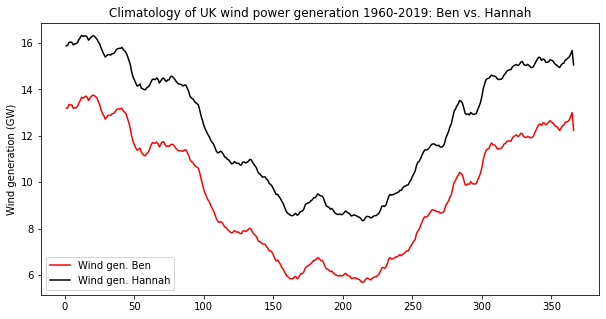

In [35]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom capacity factors
plt.plot(climatology_full.index, climatology_full["total_wind_power"], label="Wind gen. Ben", color="red")
plt.plot(climatology_full.index, climatology_full["United_Kingdom_wind_gen_ch"], label="Wind gen. Hannah", color="black")

# ylabels
plt.ylabel("Wind generation (GW)")

# legend
plt.legend()

# title
plt.title("Climatology of UK wind power generation 1960-2019: Ben vs. Hannah")

### Compare demand net wind ###

Text(0.5, 1.0, 'Climatology of UK demand net wind 1960-2019: Ben vs. Hannah')

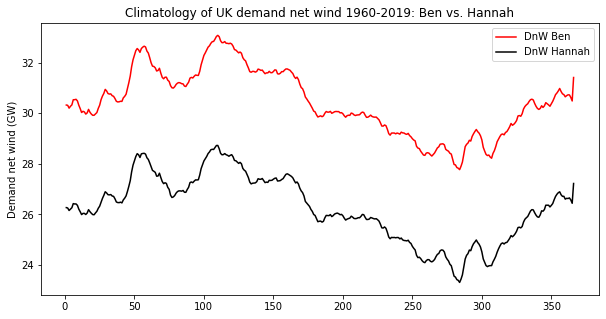

In [36]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the united kingdom capacity factors
plt.plot(climatology_full.index, climatology_full["demand_net_wind"], label="DnW Ben", color="red")
plt.plot(climatology_full.index, climatology_full["demand_net_wind_ch"], label="DnW Hannah", color="black")

# ylabels
plt.ylabel("Demand net wind (GW)")

# legend
plt.legend()

# title
plt.title("Climatology of UK demand net wind 1960-2019: Ben vs. Hannah")

### Identify spikes in demand net wind ###

Standardise annual demand net wind anomalies for both Ben and Hannah data and see whether the same events are highlighted.

In [37]:
# add total wind power to the ben_ch_df
ben_ch_df["total_wind_power"] = ben_ch_df["ons_wind_power"] + ben_ch_df["ofs_wind_power"]

# add demand net wind to the ben_ch_df
ben_ch_df["demand_net_wind"] = ben_ch_df["United_Kingdom_demand"] - ben_ch_df["total_wind_power"]

In [38]:
# remove the mean and scale by the standard deviation
ben_ch_df["ben_DnW_norm"] = (
    ben_ch_df["demand_net_wind"] - ben_ch_df["demand_net_wind"].mean()
) / ben_ch_df["demand_net_wind"].std()

ben_ch_df["hannah_DnW_norm"] = (
    ben_ch_df["demand_net_wind_ch"] - ben_ch_df["demand_net_wind_ch"].mean()
) / ben_ch_df["demand_net_wind_ch"].std()

In [39]:
# take an annual mean of ben_ch_df
ben_ch_df_annual = ben_ch_df.resample("Y").mean()

In [40]:
# remove "ben_DnW_norm" and "hannah_DnW_norm" from ben_ch_df_annual
ben_ch_df_annual.drop(["ben_DnW_norm", "hannah_DnW_norm"], axis=1, inplace=True)

In [41]:
# calculate these from the annual means
ben_ch_df_annual["ben_DnW_norm"] = (
    ben_ch_df_annual["demand_net_wind"] - ben_ch_df_annual["demand_net_wind"].mean()
) / ben_ch_df_annual["demand_net_wind"].std()

ben_ch_df_annual["hannah_DnW_norm"] = (
    ben_ch_df_annual["demand_net_wind_ch"] - ben_ch_df_annual["demand_net_wind_ch"].mean()
) / ben_ch_df_annual["demand_net_wind_ch"].std()

In [42]:
ben_ch_df_annual.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,ons_wind_power,ofs_wind_power,United_Kingdom_solar_cf_ch,...,wd_demand_net_wind_ch,demand_net_renewables_ch,wd_demand_net_renewables_ch,demandESO_ch,demandESO_net_wind_ch,demandESO_net_renewables_ch,total_wind_power,demand_net_wind,ben_DnW_norm,hannah_DnW_norm
2015-12-31,7.738390,0.327288,0.396681,9.471045,6.087753,0.000000,39.607344,4.865459,5.853426,0.090071,...,26.428030,23.581459,25.040699,NaN,NaN,NaN,10.718885,28.888459,-1.617511,-1.396303
2016-12-31,7.060306,0.266596,0.328185,9.547796,6.086492,0.000000,39.606401,3.963218,4.842701,0.089548,...,28.010662,25.163163,26.631376,NaN,NaN,NaN,8.805918,30.800482,0.349848,0.296164
2017-12-31,7.372889,0.289745,0.359340,9.847123,5.750729,0.000000,39.355382,4.307350,5.302419,0.086330,...,26.683368,23.881568,25.353659,NaN,NaN,NaN,9.609769,29.745613,-0.735551,-1.135509
2018-12-31,7.190230,0.282378,0.346931,9.741740,6.026337,0.000000,39.561429,4.197835,5.119314,0.091203,...,27.505245,24.639020,26.100474,NaN,NaN,NaN,9.317149,30.244280,-0.222452,-0.240142
2019-12-31,6.997420,0.261077,0.322753,10.470572,5.254001,0.000145,38.984024,3.881174,4.762542,0.099897,...,27.394355,24.402078,25.855669,NaN,NaN,NaN,8.643716,30.340308,-0.123644,-0.350946


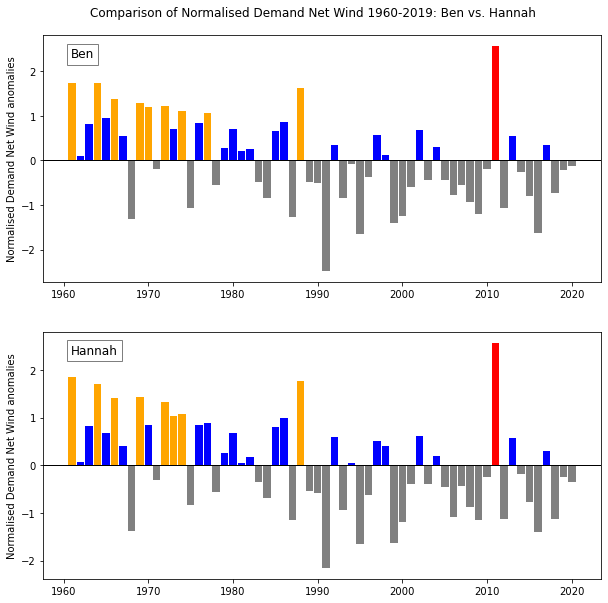

In [43]:
# set up the positive conditions
positive_conditions_ben = [
    (ben_ch_df_annual["ben_DnW_norm"] >= 0) & (ben_ch_df_annual["ben_DnW_norm"] <= 1),
    (ben_ch_df_annual["ben_DnW_norm"] >= 1) & (ben_ch_df_annual["ben_DnW_norm"] <= 2),
    (ben_ch_df_annual["ben_DnW_norm"] >= 2) & (ben_ch_df_annual["ben_DnW_norm"] <= 3),
    (ben_ch_df_annual["ben_DnW_norm"] > 3),
    (ben_ch_df_annual["ben_DnW_norm"] < 0)
]

# Set up the positive conditions hannah
positive_conditions_hannah = [
    (ben_ch_df_annual["hannah_DnW_norm"] >= 0) & (ben_ch_df_annual["hannah_DnW_norm"] <= 1),
    (ben_ch_df_annual["hannah_DnW_norm"] >= 1) & (ben_ch_df_annual["hannah_DnW_norm"] <= 2),
    (ben_ch_df_annual["hannah_DnW_norm"] >= 2) & (ben_ch_df_annual["hannah_DnW_norm"] <= 3),
    (ben_ch_df_annual["hannah_DnW_norm"] > 3),
    (ben_ch_df_annual["hannah_DnW_norm"] < 0)
]

# Set up the colours for this
colors = ["blue", "orange", "red", "purple", "gray"]

# Set up the labels
ben_ch_df_annual["colour_ben"] = np.select(positive_conditions_ben, colors, default="black")
ben_ch_df_annual["colour_hannah"] = np.select(positive_conditions_hannah, colors, default="black")

if "colour_ben" in ben_ch_df_annual.columns and "colour_hannah" in ben_ch_df_annual.columns:
    # set up the figure as 1 column 2 rows
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    bars_ben = axs[0].bar(
        ben_ch_df_annual.index,
        ben_ch_df_annual["ben_DnW_norm"],
        color=ben_ch_df_annual["colour_ben"],
        width=320.0
    )

    # Set up the bars hannah
    bars_hannah = axs[1].bar(
        ben_ch_df_annual.index,
        ben_ch_df_annual["hannah_DnW_norm"],
        color=ben_ch_df_annual["colour_hannah"],
        width=320.0
    )

    # set up a horizontal line at 0
    axs[0].axhline(0, color="black", linewidth=1)

    # set up a horizontal line at 0
    axs[1].axhline(0, color="black", linewidth=1)

    # add textbox in the top left corner
    axs[0].text(
        0.05,
        0.95,
        "Ben",
        verticalalignment="top",
        horizontalalignment="left",
        transform=axs[0].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5)
    )

    # add textbox in the top left corner
    axs[1].text(
        0.05,
        0.95,
        "Hannah",
        verticalalignment="top",
        horizontalalignment="left",
        transform=axs[1].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5)
    )

    # Set up the title
    plt.suptitle("Comparison of Normalised Demand Net Wind 1960-2019: Ben vs. Hannah", y=0.92)

    # Set up the ylabels
    axs[0].set_ylabel("Normalised Demand Net Wind anomalies")

    # Set up the ylabels
    axs[1].set_ylabel("Normalised Demand Net Wind anomalies")
    

Would be useful to do the same but for ONDJFM specifically. To see whether they both capture the same winter wind droughts.

In [44]:
# subset the ben_ch_df to months 10, 11, 12, 1, 2, 3
winter_df = ben_ch_df.loc[ben_ch_df.index.month.isin([10, 11, 12, 1, 2, 3])]

# shift time back by 3 months and take the annual mean
winter_df_annual = winter_df.shift(-3, freq="M").resample("Y").mean()

In [46]:
winter_df_annual.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,ons_wind_power,ofs_wind_power,United_Kingdom_solar_cf_ch,...,wd_demand_net_wind_ch,demand_net_renewables_ch,wd_demand_net_renewables_ch,demandESO_ch,demandESO_net_wind_ch,demandESO_net_renewables_ch,total_wind_power,demand_net_wind,ben_DnW_norm,hannah_DnW_norm
2015-12-31,8.531223,0.404517,0.482159,7.090087,8.409913,0.0,41.343411,6.013546,7.114741,0.061521,...,26.183721,23.780872,25.236124,NaN,NaN,NaN,13.128287,28.215123,-0.315901,-0.212530
2016-12-31,7.554952,0.308168,0.379930,6.674508,8.825492,0.0,41.654101,4.581224,5.606248,0.059247,...,28.476850,26.101043,27.564292,NaN,NaN,NaN,10.187472,31.466629,0.146380,0.107969
2017-12-31,8.334945,0.377788,0.461215,5.786028,9.713972,0.0,42.318336,5.616204,6.805692,0.058692,...,26.933079,24.565822,26.029071,NaN,NaN,NaN,12.421896,29.896440,-0.076861,-0.108551
2018-12-31,8.168176,0.363134,0.441149,6.994612,8.505388,0.0,41.414789,5.398348,6.509588,0.059892,...,26.676840,24.291091,25.754340,NaN,NaN,NaN,11.907936,29.506853,-0.132250,-0.144489
2019-12-31,7.598898,0.304425,0.379030,9.454304,6.045696,0.0,39.575902,4.525583,5.592967,0.064034,...,26.075510,23.723507,25.089206,NaN,NaN,NaN,10.118550,29.457352,-0.139288,-0.215147


In [47]:
# remove "ben_DnW_norm" and "hannah_DnW_norm" from ben_ch_df_annual
winter_df_annual.drop(["ben_DnW_norm", "hannah_DnW_norm"], axis=1, inplace=True)

In [48]:
# calculate from the winter annual means
winter_df_annual["ben_DnW_norm"] = (
    winter_df_annual["demand_net_wind"] - winter_df_annual["demand_net_wind"].mean()
) / winter_df_annual["demand_net_wind"].std()

winter_df_annual["hannah_DnW_norm"] = (
    winter_df_annual["demand_net_wind_ch"] - winter_df_annual["demand_net_wind_ch"].mean()
) / winter_df_annual["demand_net_wind_ch"].std()

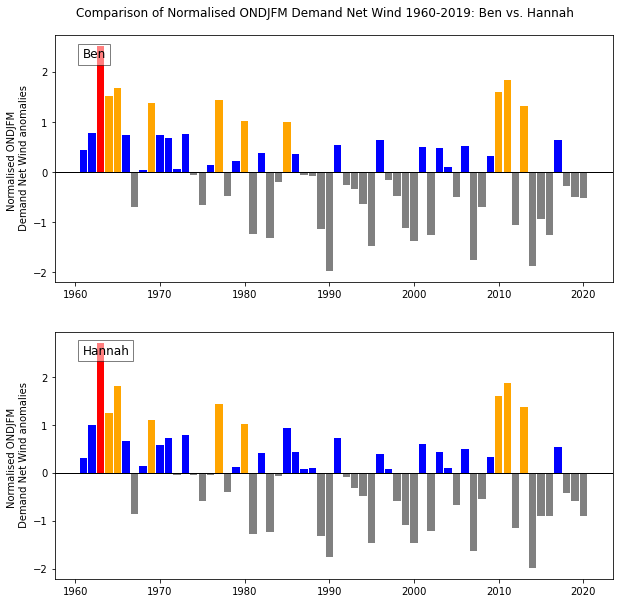

In [49]:
# Set up positive conditions ben
positive_conditions_ben = [
    (winter_df_annual["ben_DnW_norm"] >= 0) & (winter_df_annual["ben_DnW_norm"] <= 1),
    (winter_df_annual["ben_DnW_norm"] >= 1) & (winter_df_annual["ben_DnW_norm"] <= 2),
    (winter_df_annual["ben_DnW_norm"] >= 2) & (winter_df_annual["ben_DnW_norm"] <= 3),
    (winter_df_annual["ben_DnW_norm"] > 3),
    (winter_df_annual["ben_DnW_norm"] < 0)
]

# Set up positive conditions hannah
positive_conditions_hannah = [
    (winter_df_annual["hannah_DnW_norm"] >= 0) & (winter_df_annual["hannah_DnW_norm"] <= 1),
    (winter_df_annual["hannah_DnW_norm"] >= 1) & (winter_df_annual["hannah_DnW_norm"] <= 2),
    (winter_df_annual["hannah_DnW_norm"] >= 2) & (winter_df_annual["hannah_DnW_norm"] <= 3),
    (winter_df_annual["hannah_DnW_norm"] > 3),
    (winter_df_annual["hannah_DnW_norm"] < 0)
]

# Set up the colours for this
colors = ["blue", "orange", "red", "purple", "gray"]

# Set up the labels
winter_df_annual["colour_ben"] = np.select(positive_conditions_ben, colors, default="black")
winter_df_annual["colour_hannah"] = np.select(positive_conditions_hannah, colors, default="black")

if "colour_ben" in winter_df_annual.columns and "colour_hannah" in winter_df_annual.columns:
    # Set up the figure as 1 column 2 rows
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Set up the bars ben
    bars_ben = axs[0].bar(
        winter_df_annual.index,
        winter_df_annual["ben_DnW_norm"],
        color=winter_df_annual["colour_ben"],
        width=320.0
    )

    # Set up the bars hannah
    bars_hannah = axs[1].bar(
        winter_df_annual.index,
        winter_df_annual["hannah_DnW_norm"],
        color=winter_df_annual["colour_hannah"],
        width=320.0
    )

    # Set up a horizontal line at 0
    axs[0].axhline(0, color="black", linewidth=1)

    # Set up a horizontal line at 0
    axs[1].axhline(0, color="black", linewidth=1)

    # Add textbox in the top left corner
    axs[0].text(
        0.05,
        0.95,
        "Ben",
        verticalalignment="top",
        horizontalalignment="left",
        transform=axs[0].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5)
    )

    # Add textbox in the top left corner
    axs[1].text(
        0.05,
        0.95,
        "Hannah",
        verticalalignment="top",
        horizontalalignment="left",
        transform=axs[1].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5)
    )

    # Set up the title
    plt.suptitle("Comparison of Normalised ONDJFM Demand Net Wind 1960-2019: Ben vs. Hannah", y=0.92)

    # Set up the ylabels
    axs[0].set_ylabel("Normalised ONDJFM \n Demand Net Wind anomalies")

    # Set up the ylabels
    axs[1].set_ylabel("Normalised ONDJFM \n Demand Net Wind anomalies")


Looks pretty similar, seems to mostly capture the same events. The only difference is the wind. One difference is that Hannah converts hourly data to wind power Cfs and then we take the daily mean of that here. Another difference could be the distribution of wind farms. Hannah may be using 2023, leading to higher wind Cfs. Hannah's wind speeds at hub height are higher. If we don't care about the absolute values, then my conversions seem okay!